# Synthetic observations - Phantom model
---

In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import torch

from astropy     import units, constants
from pomme.model import TensorModel
from pomme.haar  import Haar
from pomme.plot  import plot_cube_2D
from pomme.utils import planck, T_CMB

from phantom import lines, fracs, velos, Model

You have selected line:
    CO(J=4-3)
Please check the properties that were inferred:
    Frequency         4.610407682e+11  Hz
    Einstein A coeff  6.126000000e-06  1/s
    Molar mass        28.0101          g/mol
You have selected line:
    sio-h2(J=03-02)
Please check the properties that were inferred:
    Frequency         1.302686830e+11  Hz
    Einstein A coeff  1.058000000e-04  1/s
    Molar mass        44.0849          g/mol


/home/frederikd/.local/lib/python3.9/site-packages/astroquery/lamda/core.py:145: UserWarning: The first time a LAMDA function is called, it must assemble a list of valid molecules and URLs.  This list will be cached so future operations will be faster.
  warnings.warn("The first time a LAMDA function is called, it must "


In [2]:
import plons

setupData = plons.LoadSetup('/STER/frederikd/', "wind")
dumpData  = plons.LoadFullDump('/STER/frederikd/wind_00600', setupData)

position = dumpData["position"]*1e-2     # position vectors        [cm   -> m]
velocity = dumpData["velocity"]*1e3      # velocity vectors        [km/s -> m/s]
rho      = dumpData["rho"]               # density                 [g/cm^3]
tmp      = dumpData["Tgas"]              # temperature             [K]
tmp[tmp<T_CMB] = T_CMB                   # Cut-off temperatures below 2.725 K

v_x, v_y, v_z = velocity[:,0], velocity[:,1], velocity[:,2]

# Convert rho (total density) to abundances
nH2 = rho * 1.0e+6 * constants.N_A.si.value / 2.02

# Define turbulence at 150 m/s
trb = 150.0

# Map point data to a regular grid
haar = Haar(position, q=8)

imin = 2**(haar.q-3)
imax = 3*imin

nH2_dat = haar.map_data(nH2, interpolate=True)[-1][imin:imax,imin:imax,imin:imax]
tmp_dat = haar.map_data(tmp, interpolate=True)[-1][imin:imax,imin:imax,imin:imax]
v_x_dat = haar.map_data(v_x, interpolate=True)[-1][imin:imax,imin:imax,imin:imax]
v_y_dat = haar.map_data(v_y, interpolate=True)[-1][imin:imax,imin:imax,imin:imax]
v_z_dat = haar.map_data(v_z, interpolate=True)[-1][imin:imax,imin:imax,imin:imax]

assert tmp_dat.shape == nH2_dat.shape
assert tmp_dat.shape == v_z_dat.shape

model = TensorModel(shape=nH2_dat.shape, sizes=haar.xyz_L)
model['log_H2'          ] = np.log(nH2_dat).astype(np.float64)
model['log_temperature' ] = np.log(tmp_dat).astype(np.float64)
model['velocity_x'      ] =        v_x_dat .astype(np.float64)
model['velocity_y'      ] =        v_y_dat .astype(np.float64)
model['velocity_z'      ] =        v_z_dat .astype(np.float64)
model['log_v_turbulence'] = np.log(trb)*np.ones(model.shape, dtype=np.float64)

In [3]:
def get_boundary_condition(model, freq):
    Ibdy  = torch.ones((model.shape[0], model.shape[1], len(freq)), dtype=torch.float64)
    Ibdy *= planck(temperature=T_CMB, frequency=freq)
    return Ibdy

In [4]:
pmodel = Model(model=model, lines=lines, fracs=fracs, velos=velos)
pmodel.get_velocity           = lambda model: model['velocity_z']
pmodel.get_abundance          = lambda model: torch.exp(model['log_H2'])
pmodel.get_turbulence         = lambda model: torch.exp(model['log_v_turbulence'])
pmodel.get_temperature        = lambda model: torch.exp(model['log_temperature'])
pmodel.get_boundary_condition = get_boundary_condition

In [5]:
obss = pmodel.image()

In [6]:
plot_cube_2D(np.log(obss[1]))

interactive(children=(IntSlider(value=49, description='z', max=99), Output()), _dom_classes=('widget-interact'…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

In [12]:
obss.shape

torch.Size([2, 64, 64, 100])

In [10]:
velos

tensor([-12000.0000, -11757.5758, -11515.1515, -11272.7273, -11030.3030,
        -10787.8788, -10545.4545, -10303.0303, -10060.6061,  -9818.1818,
         -9575.7576,  -9333.3333,  -9090.9091,  -8848.4848,  -8606.0606,
         -8363.6364,  -8121.2121,  -7878.7879,  -7636.3636,  -7393.9394,
         -7151.5152,  -6909.0909,  -6666.6667,  -6424.2424,  -6181.8182,
         -5939.3939,  -5696.9697,  -5454.5455,  -5212.1212,  -4969.6970,
         -4727.2727,  -4484.8485,  -4242.4242,  -4000.0000,  -3757.5758,
         -3515.1515,  -3272.7273,  -3030.3030,  -2787.8788,  -2545.4545,
         -2303.0303,  -2060.6061,  -1818.1818,  -1575.7576,  -1333.3333,
         -1090.9091,   -848.4848,   -606.0606,   -363.6364,   -121.2121,
           121.2121,    363.6364,    606.0606,    848.4848,   1090.9091,
          1333.3333,   1575.7576,   1818.1818,   2060.6061,   2303.0303,
          2545.4545,   2787.8788,   3030.3030,   3272.7273,   3515.1515,
          3757.5758,   4000.0000,   4242.4242,   44

In [17]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [25]:
model.sizes / (1.0 * units.au).si.value

array([499.14966283, 498.78355716, 492.07092181])

In [27]:
32 - 32 / 250 * 150

12.8

In [28]:
32 + 32 / 250 * 150

51.2

In [23]:
obs.shape

torch.Size([64, 64, 100])

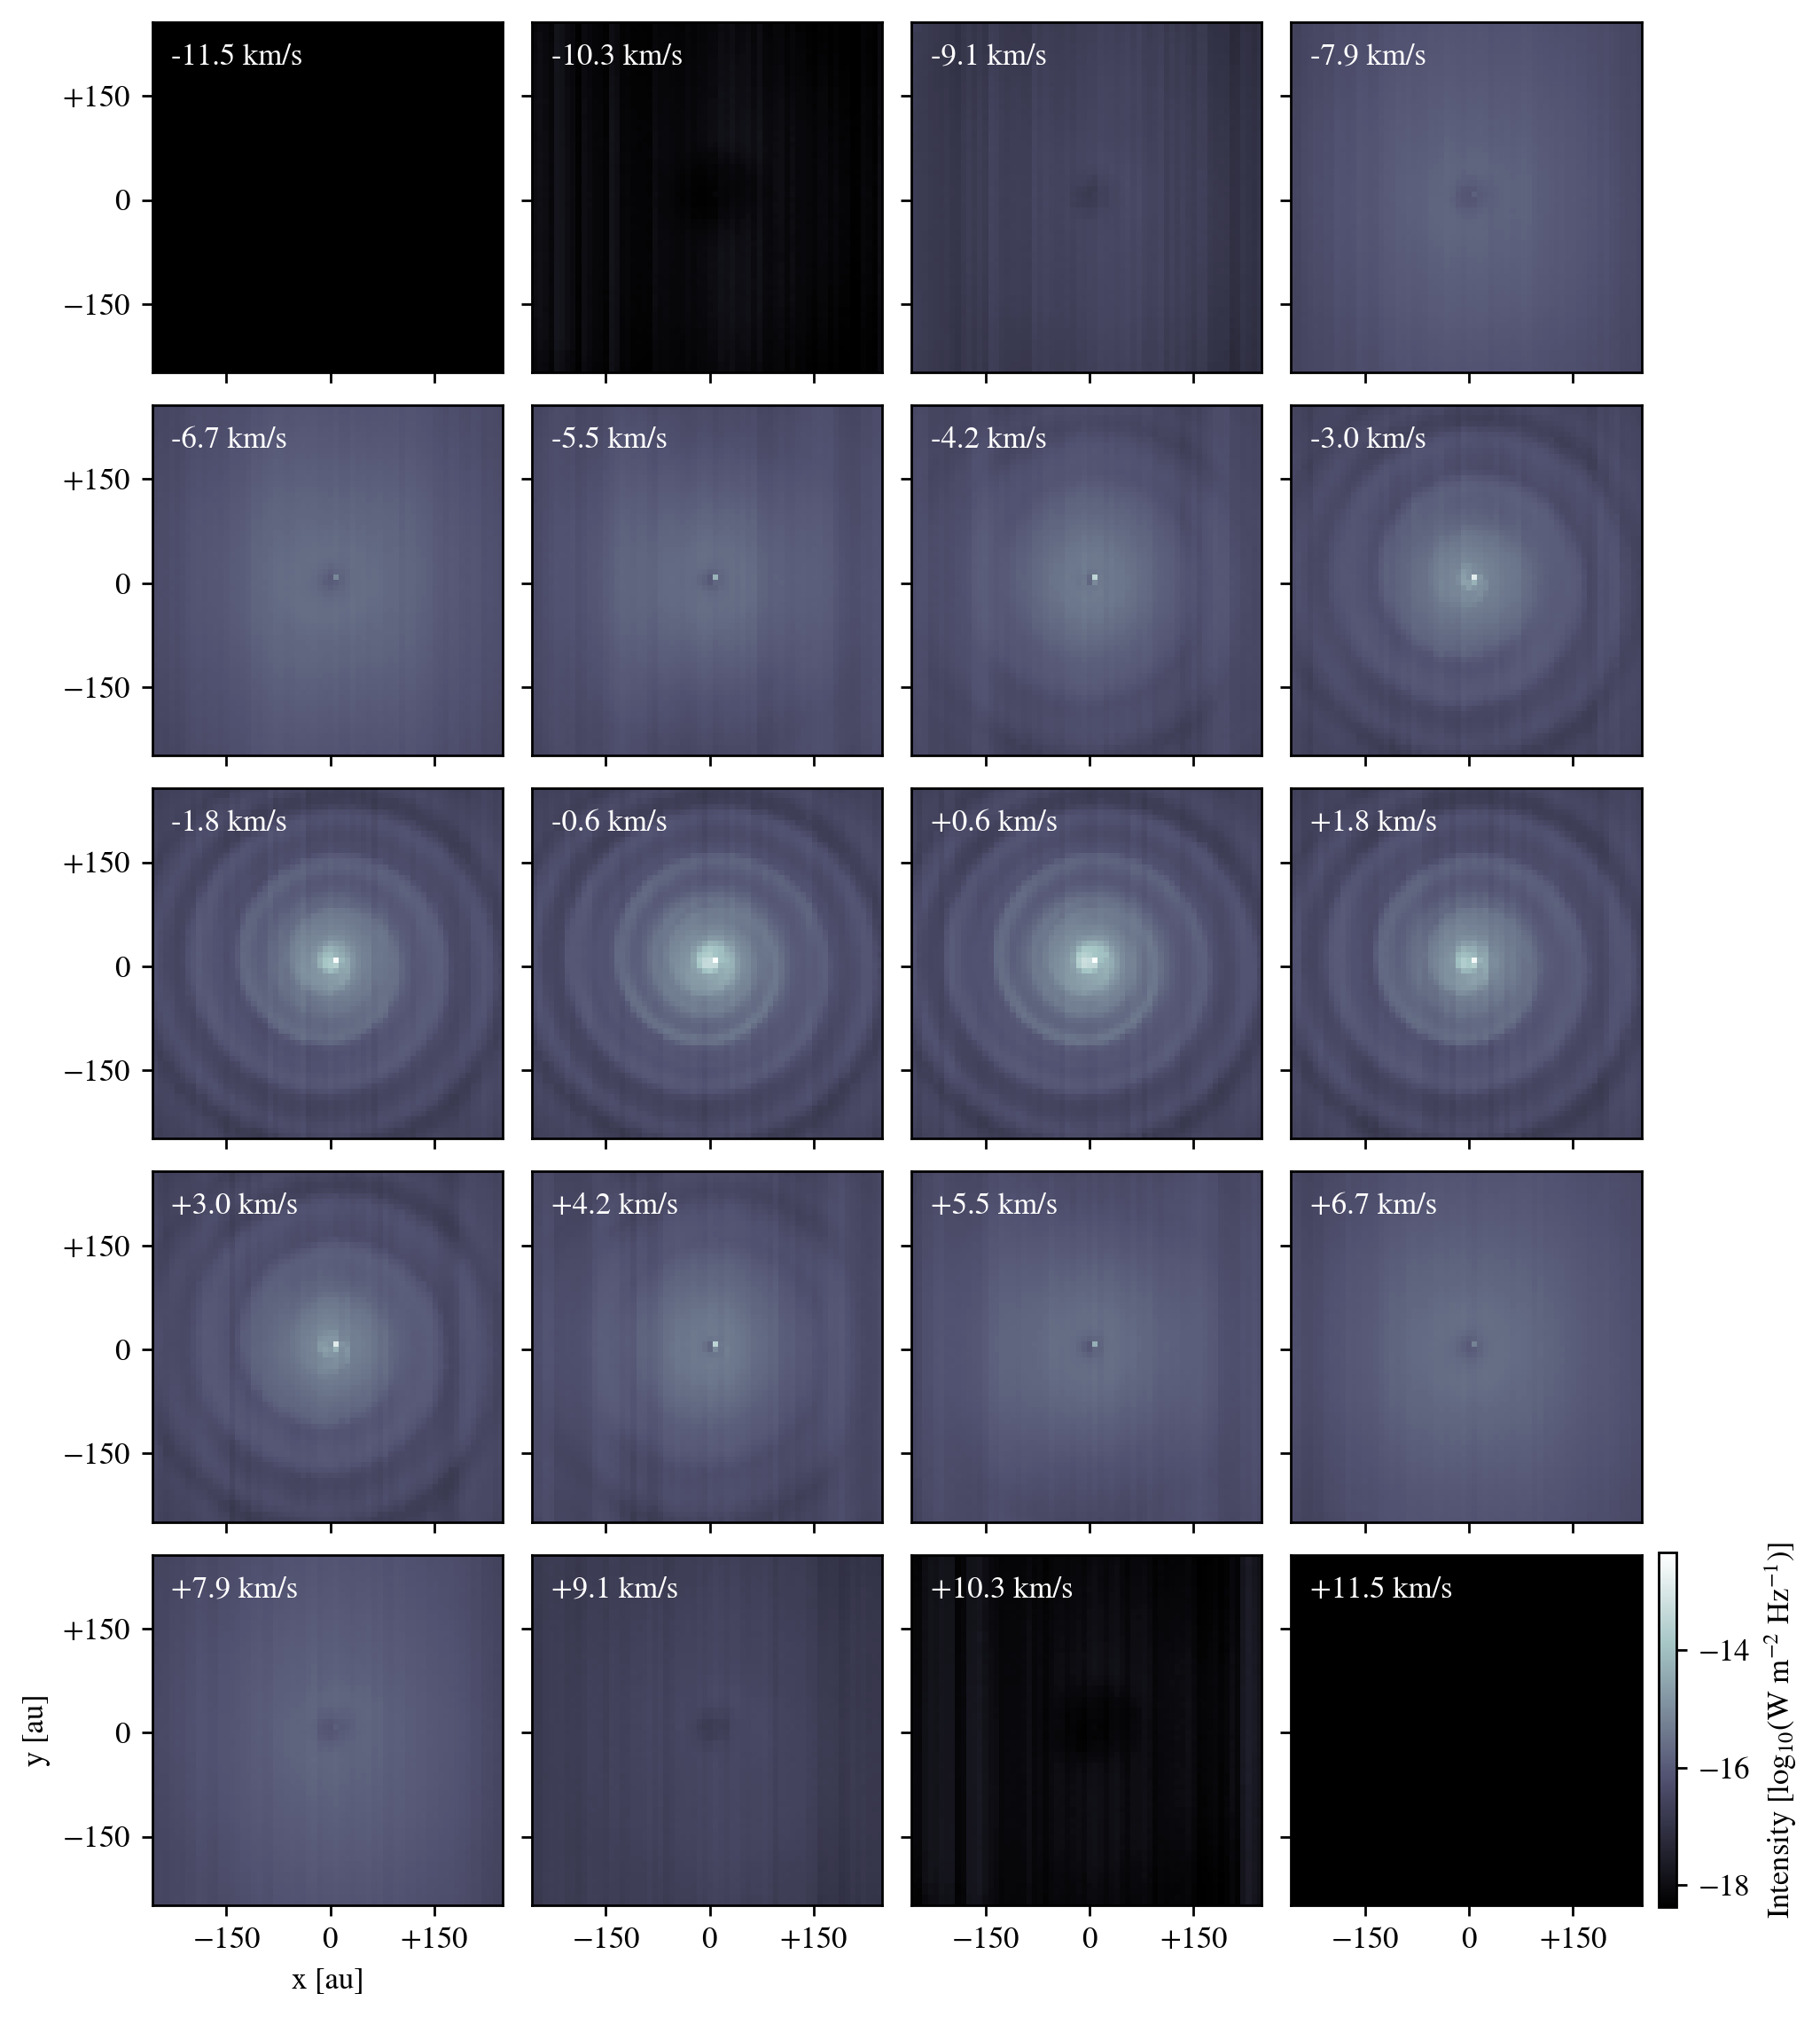

In [66]:
obs = obss[0]

vmin = np.log10(obs.min())
vmax = np.log10(obs.max())

fig, axes = plt.subplots(
    nrows       =   5,
    ncols       =   4,
    dpi         = 250,
    sharex      = True,
    sharey      = True,
    figsize     = (8.1, 9),
    gridspec_kw = {'wspace':0.00, 'hspace':0.00},
    layout      = 'constrained'
)

for i, ax in enumerate(axes.ravel()):
    pcm = ax.imshow(np.log10(obs[:,:,5*i+2]), vmin=vmin, vmax=vmax, cmap='bone')
    ax.text(+3, +7.25, f'{velos[5*i+2]/1000:+.1f} km/s', color='white')
    # ax.get_xaxis().set_visible(False)
    # ax.get_yaxis().set_visible(False)
    ax.set_xticks([13, 32, 51], ['$-150$', '$0$', '$+150$'])
    ax.set_yticks([13, 32, 51], ['$+150$', '$0$', '$-150$'])
    
axes[4,0].set_xlabel('x [au]')
axes[4,0].set_ylabel('y [au]')

fig.colorbar(pcm, ax=ax, location='right', shrink=1.0, pad=0.05, label='Intensity [log$_{10}$(W m$^{-2}$ Hz$^{-1}$)]')

plt.savefig('phantom_CO_obs.png', dpi=360)

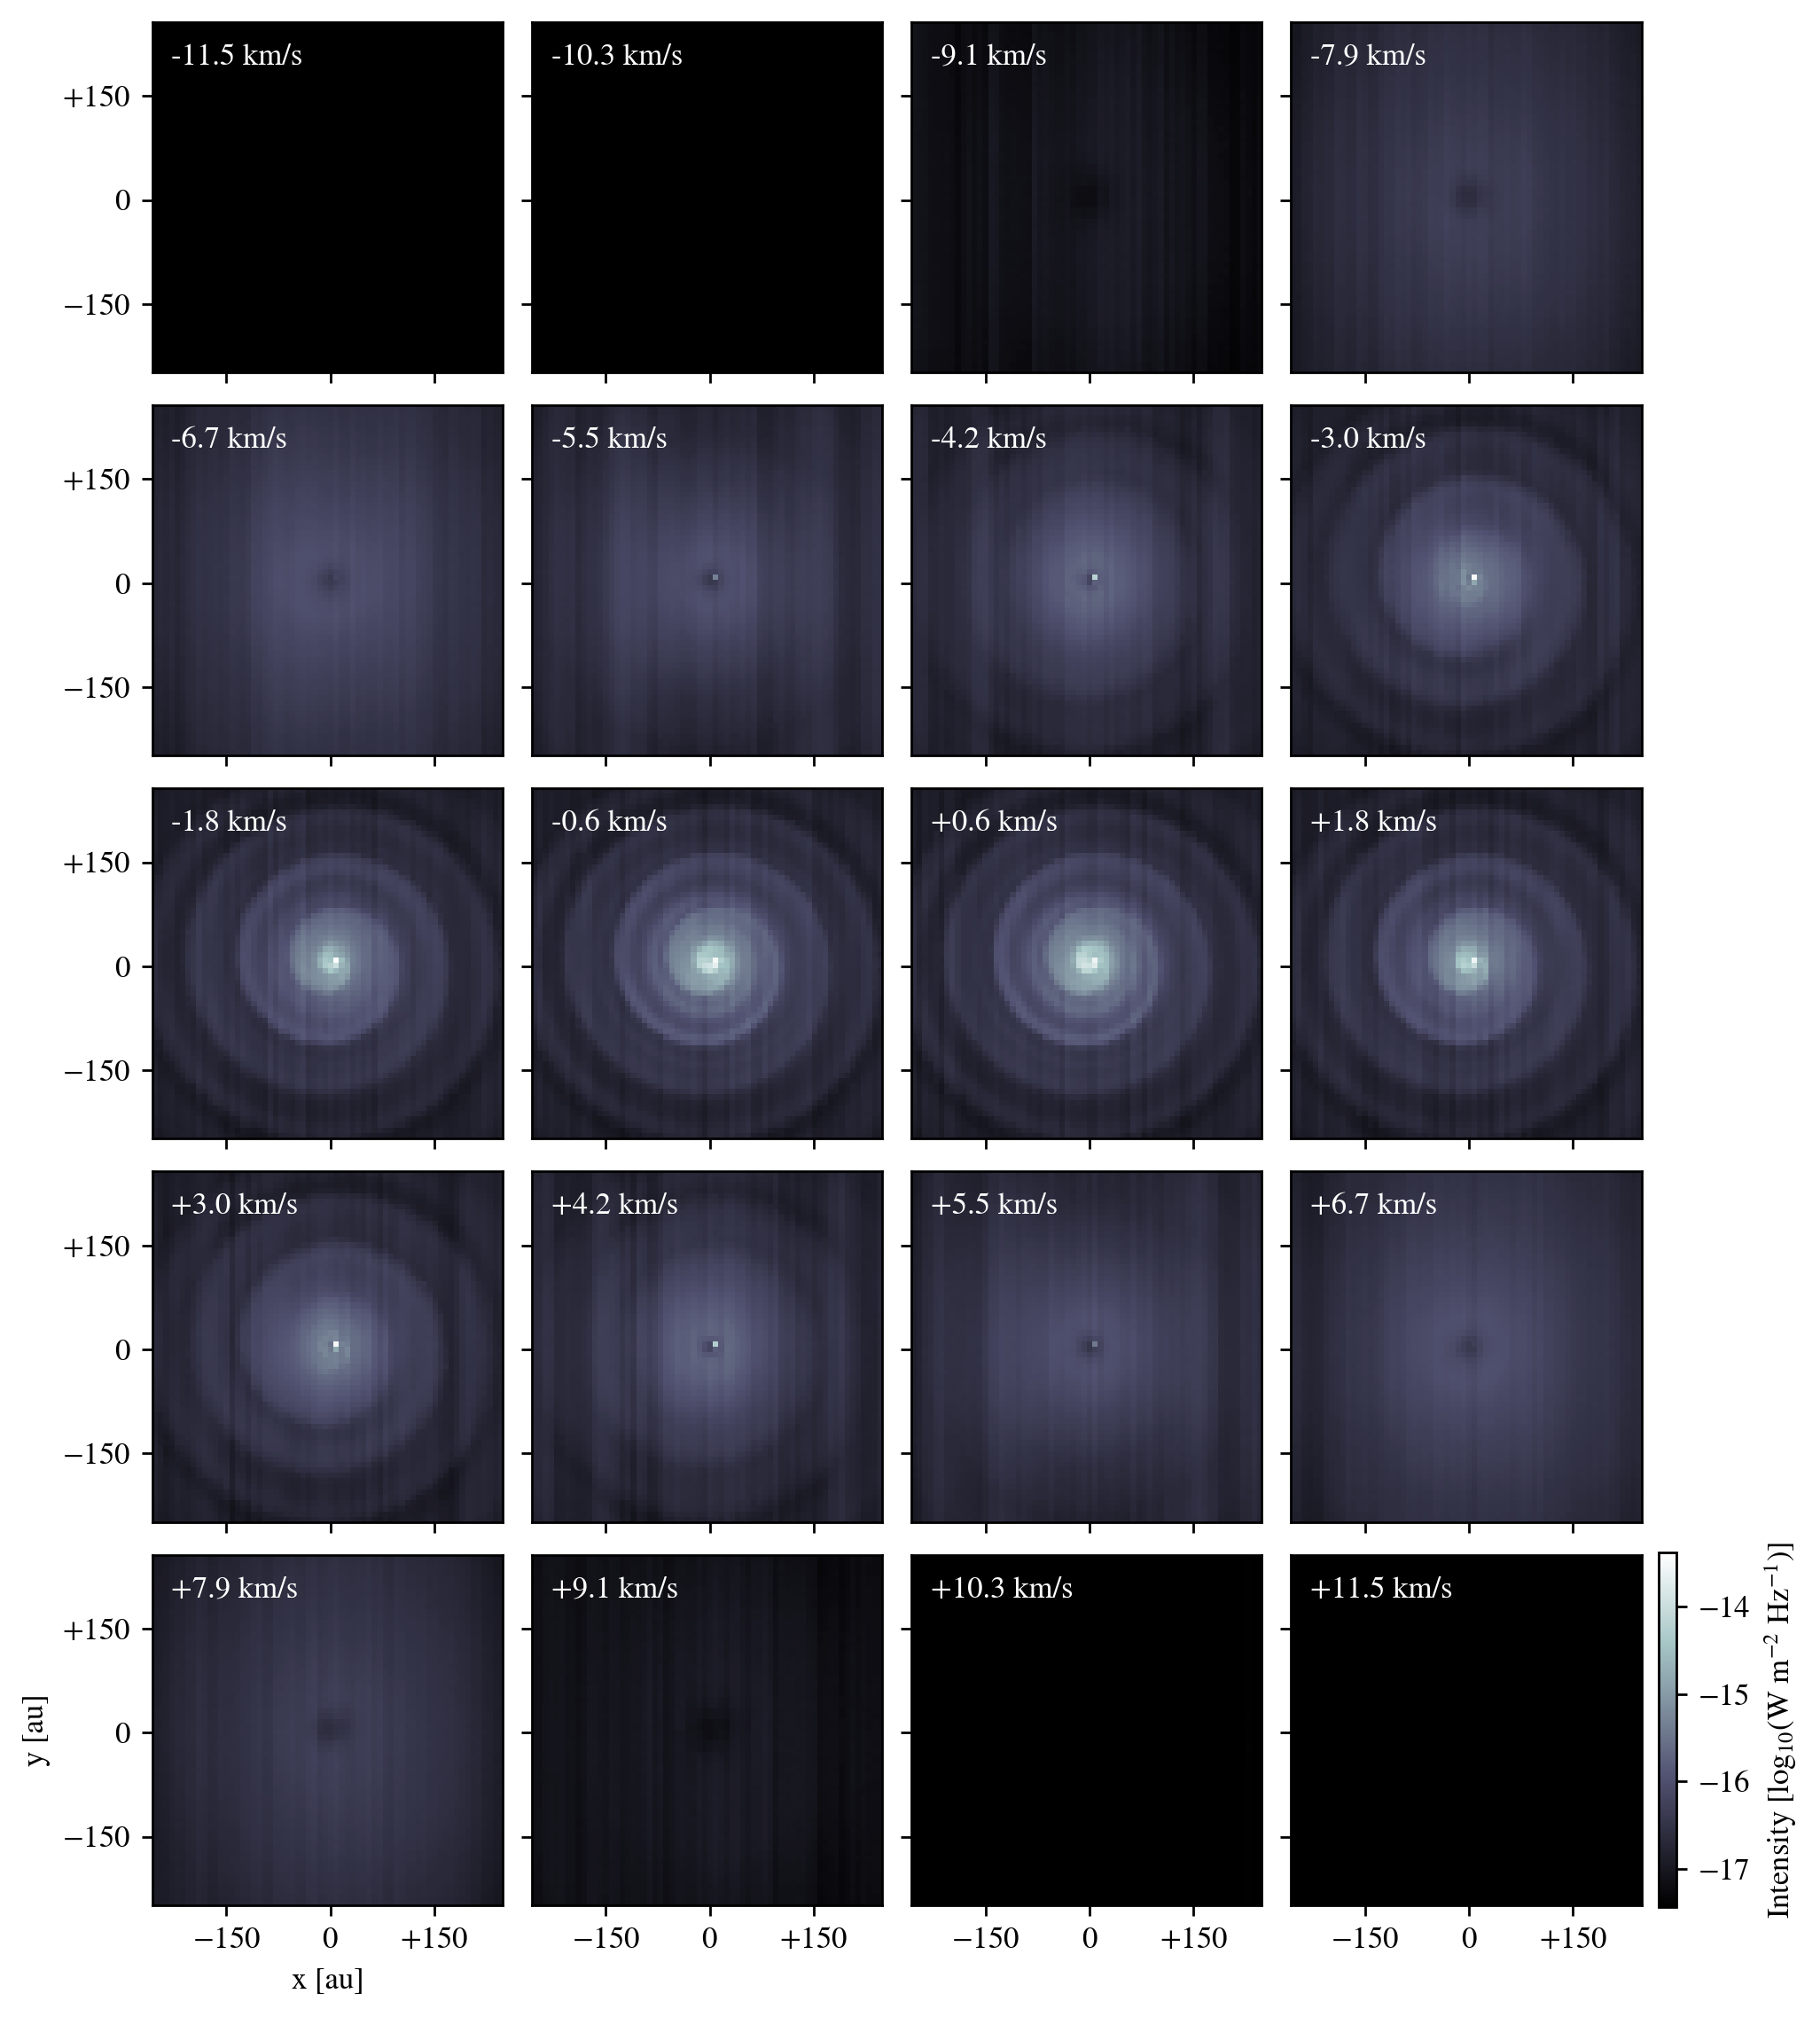

In [65]:
obs = obss[1]

vmin = np.log10(obs.min())
vmax = np.log10(obs.max())

fig, axes = plt.subplots(
    nrows       =   5,
    ncols       =   4,
    dpi         = 250,
    sharex      = True,
    sharey      = True,
    figsize     = (8.1, 9),
    gridspec_kw = {'wspace':0.00, 'hspace':0.00},
    layout      = 'constrained'
)

for i, ax in enumerate(axes.ravel()):
    pcm = ax.imshow(np.log10(obs[:,:,5*i+2]), vmin=vmin, vmax=vmax, cmap='bone')
    ax.text(+3, +7.25, f'{velos[5*i+2]/1000:+.1f} km/s', color='white')
    # ax.get_xaxis().set_visible(False)
    # ax.get_yaxis().set_visible(False)
    ax.set_xticks([13, 32, 51], ['$-150$', '$0$', '$+150$'])
    ax.set_yticks([13, 32, 51], ['$+150$', '$0$', '$-150$'])
    
axes[4,0].set_xlabel('x [au]')
axes[4,0].set_ylabel('y [au]')

fig.colorbar(pcm, ax=ax, location='right', shrink=1.0, pad=0.05, label='Intensity [log$_{10}$(W m$^{-2}$ Hz$^{-1}$)]')

plt.savefig('phantom_SiO_obs.png', dpi=360)

In [7]:
plot_cube_2D(np.log(obss[0]))

interactive(children=(IntSlider(value=49, description='z', max=99), Output()), _dom_classes=('widget-interact'…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

In [8]:
obss_int = obss.sum(axis=(1,2))

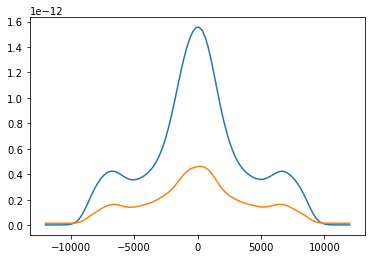

In [9]:
plt.plot(pmodel.velos, obss_int[0])
plt.plot(pmodel.velos, obss_int[1])

In [10]:
torch.save(obss, 'obss.pt')

In [11]:
model.save('model_truth.h5')